In [1]:
import pandas as pd
import os
import numpy as np
script_dir = '/home/local/PSYCH-ADS/xuqian_chen/Github/effective-altruism/1_code'
data_folder_path = os.path.join(os.path.dirname(script_dir),'0_data')
out_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/out')
tmp_folder_path =os.path.join(os.path.dirname(script_dir), '2_pipeline/tmp')

d = pd.read_excel(os.path.join(data_folder_path, 'combined_groups_alldata_LU_update.xlsx'), sheet_name="complete")
dfintake = pd.read_excel(os.path.join(data_folder_path, 'combined_groups_alldata_LU_update.xlsx'),sheet_name="no empty entries")
df = pd.merge(d, dfintake, on='participant_ID', how='left')
df['group'] = df['group.1']

df['event_label'] = df['event_type'].replace({-1: 'No Event', 1: 'Moral Commit', 2: 'Moral Target', 3: 'Moral Witness', 4: 'Moral Learn', 5: 'Immoral Commit', 6: 'Immoral Target', 7: 'Immoral Witness', 8: 'Immoral Learn'})
df['event_label'] = df['event_label'].astype('category')

# create a new column for moral valence based on event_type into -1 (Labeled as Neutral), 1(labeled as Moral), 2(labeled as Immoral)
df['moral_valence'] = df['event_type'].replace({-1: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2})

# create a new column for moral agency based on event_type into -1 (Labeled as Neutral), 1(labeled as Self), 2(labeled as Other)
df['moral_agency'] = df['event_type'].replace({-1: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 2, 7: 2, 8: 2})

# create a new column for moral rightness based on the variables which names start with 'Taken together', if one is missing, take the value from the other one
moraljudgevar = [i for i in df.columns if 'Taken together' in i]
df['moraljudge'] = np.where(df[moraljudgevar[0]].isnull(), df[moraljudgevar[1]], df[moraljudgevar[0]])
df['onlymoraljudge'] = df[moraljudgevar[0]]


positive_varnames = ['grateful', 'elevated', 'proud', 'happiness']
negative_varnames = ['embarrassed', 'angry', 'disgusted', 'contemptuous', 'guilty', 'shameful']

# create a new variable for positive emotion, average the positive emotion variables; do the same for nagative emotion variables
df['pos'] = df[positive_varnames].mean(axis=1)
df['neg'] = df[negative_varnames].mean(axis=1)

# delete the only one row where pos is nan, other values are nan too
df = df[df['pos'].notna()]



In [6]:
# variables that varname contains "In as few words "
textvar = [i for i in df.columns if 'In as few words' in i]
dftext = pd.DataFrame()
dftext["sig_order"] = df["sig_order"]
dftext["participant_ID"] = df["participant_ID"]
dftext['moraltext'] = df[textvar[0]]
dftext['immoraltext'] = df[textvar[1]]
dftext['neutraltext'] = df[textvar[2]]

dftext['text'] = dftext['moraltext'].fillna(dftext['immoraltext']).fillna(dftext['neutraltext'])
# delete if text is nan
dftext = dftext[dftext['text'].notna()]


dftext.to_csv(os.path.join(out_folder_path, 'dftext.csv'), index=False)

In [82]:
# print how many rows when both test[0] and test[1] are 0
print(len(df[(df[ test[0] ] == 0) & (df[test[1]] == 0)]))

2873


In [67]:

# variable valence as category
# d['valence'] = df['valence'].astype('category')

# distribution of valence
d['valence'].value_counts()

valence
immoral    1
Name: count, dtype: int64

In [62]:
dfnoneutral = df[df['event_type'] != 0]
dfnoneutral[moraljudgevar[0]].value_counts()

Taken together, how morally right or wrong was this ([QID473-ChoiceTextEntryValue][QID591-ChoiceTextEntryValue])?\n(note: the easiest way to use the slider is to tap to where you want it to go) - Taken together, how morally right or wrong was this (${q://QID473/ChoiceTextEntryValue}${q://QID591/ChoiceTextEntryValue})?\n(note: the easiest way to use the slider is to tap to where you want it to go)
 3.0    350
 2.0    247
 1.0    199
-1.0    163
-2.0    121
-3.0    117
 0.0     26
Name: count, dtype: int64

# Descriptive plots across groups

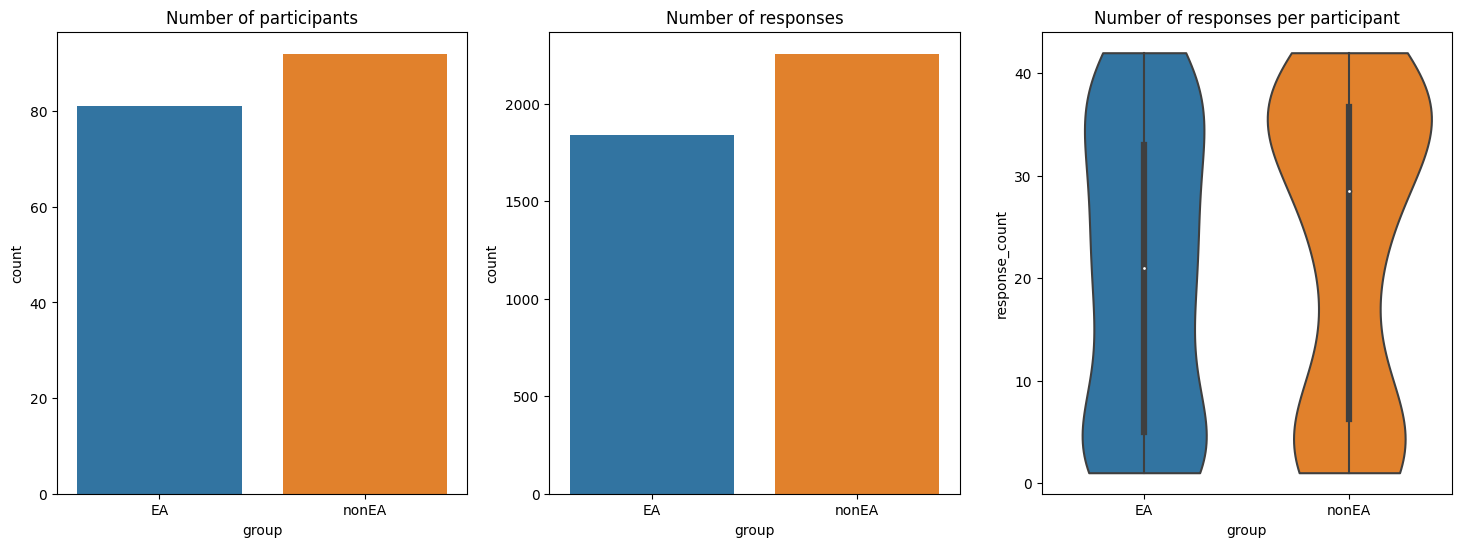

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# set sns style
sns.color_palette("colorblind")

# Count number of responses per participant within each group
response_counts = df.groupby(['group', 'participant_ID']).size().reset_index(name='response_count')

# Create two count plot for the 'group' variable, one is df, one is dfintake; plus a frequency plot group by participant_ID, different color annotated group, for df
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.countplot(ax=axes[0], x='group', data=dfintake)
sns.countplot(ax=axes[1], x='group', data=d)
# plot violine plot for response_count, limit the min y to 0
sns.violinplot(ax=axes[2], x='group', y='response_count', data = response_counts, cut=0)

# set title
axes[0].set_title('Number of participants')
axes[1].set_title('Number of responses')
axes[2].set_title('Number of responses per participant')
plt.show()

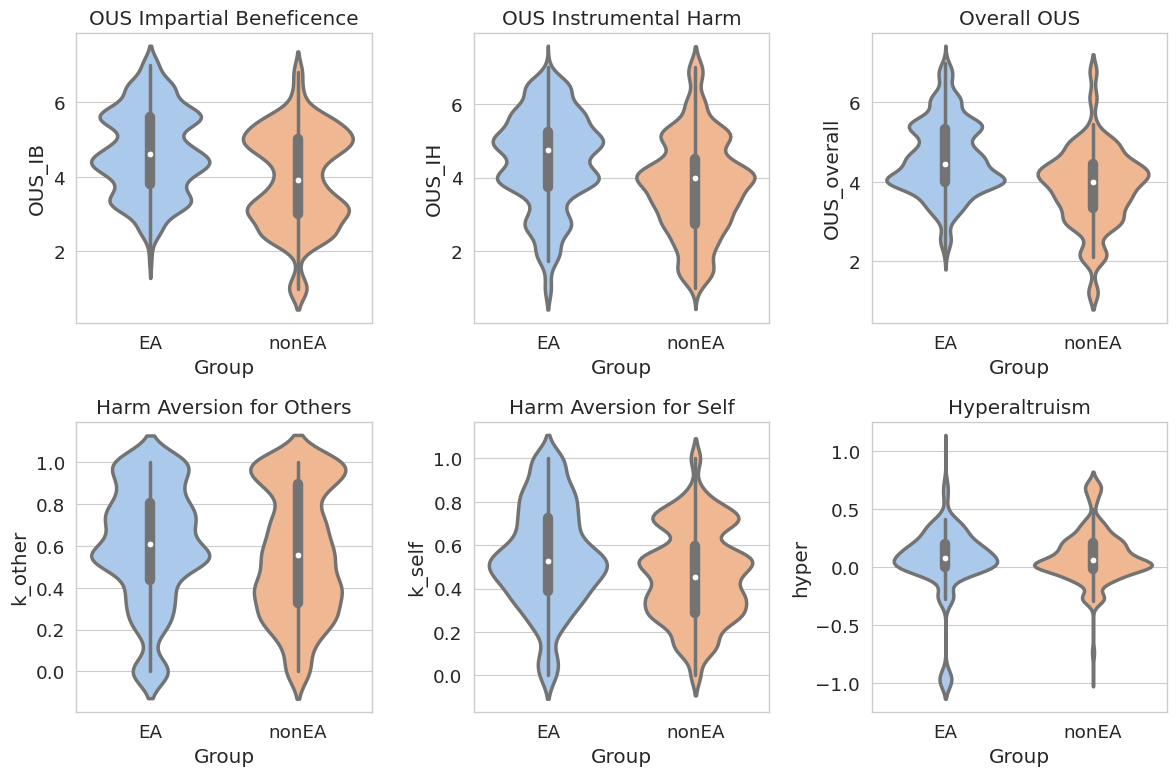

In [161]:

# plot ous variables historgrams across groups in 2 rows and 3 columns
ous_vars = ['OUS_IB', 'OUS_IH', 'OUS_overall', 'k_other', 'k_self','hyper']
ous_titles = ['OUS Impartial Beneficence', 'OUS Instrumental Harm', 'Overall OUS', 
              'Harm Aversion for Others', 'Harm Aversion for Self', 'Hyperaltruism']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    try:
        sns.violinplot(x='group', y=ous_vars[i], data=df, ax=ax)
    except:
        continue
    ax.set_xlabel('Group')
    ax.set_ylabel(ous_vars[i])
    ax.set_title(ous_titles[i])
plt.tight_layout()
plt.show()

In [70]:
from scipy.stats import ttest_ind

group_EA = dfintake[dfintake['group'] == 'EA']
group_nonEA = dfintake[dfintake['group'] == 'nonEA']

for var in ous_vars:
    t_stat, p_val = ttest_ind(group_EA[var], group_nonEA[var], nan_policy='omit')
    mean_EA = round(group_EA[var].mean(), 2)
    mean_nonEA = round(group_nonEA[var].mean(), 2)
    if mean_EA > mean_nonEA:
        higher_group = "EA"
    else:
        higher_group = "nonEA"
    print(var, " | t_stat: ", round(t_stat, 2), "p_val: ", round(p_val, 2), "higher_group: ", higher_group)
    


OUS_IB  | t_stat:  3.76 p_val:  0.0 higher_group:  EA
OUS_IH  | t_stat:  3.07 p_val:  0.0 higher_group:  EA
OUS_overall  | t_stat:  4.49 p_val:  0.0 higher_group:  EA
k_other  | t_stat:  1.01 p_val:  0.32 higher_group:  EA
k_self  | t_stat:  2.15 p_val:  0.03 higher_group:  EA


# Moral and Emoitonal Experience

## Moral Experience

In [113]:
# count nan in onlymoraljudge
df['onlymoraljudge'].isnull().sum()

2872

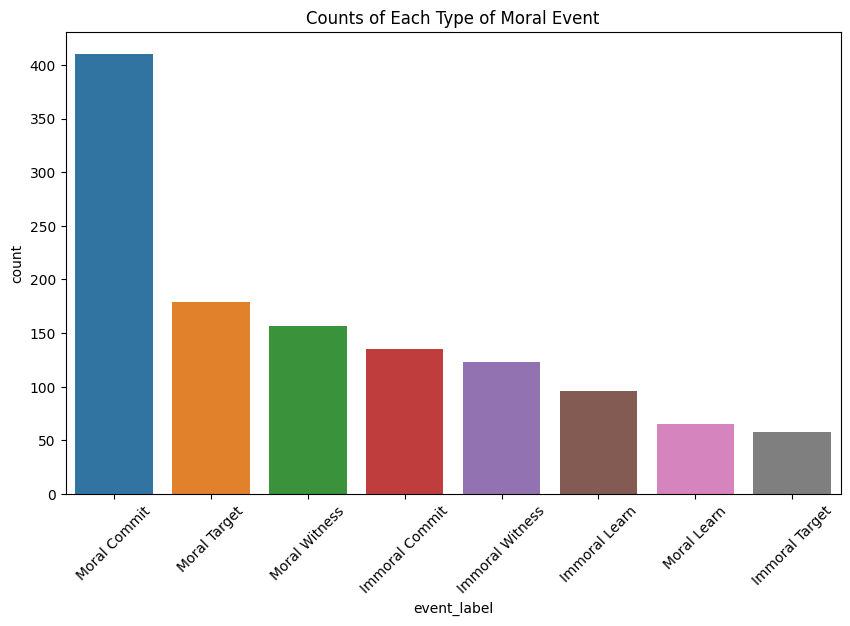

In [101]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="event_label", order=df['event_label'].value_counts().index)
plt.title("Counts of Each Type of Moral Event")
plt.xticks(rotation=45)
plt.show()


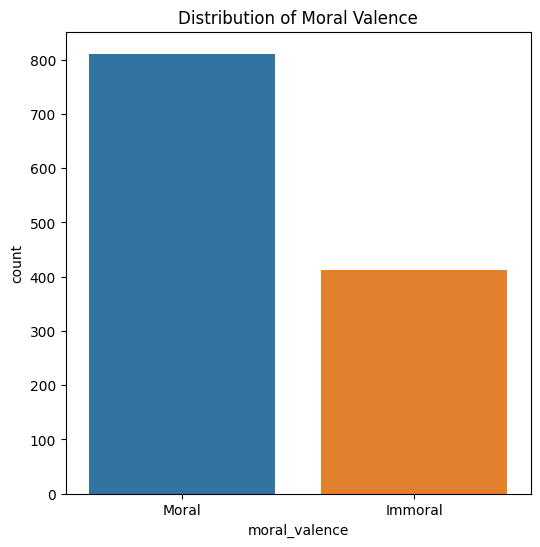

In [33]:
plt.figure(figsize=(6,6))
sns.countplot(data=df, x="moral_valence")
plt.title("Distribution of Moral Valence")
plt.xticks(ticks=[0,1], labels=["Moral", "Immoral"])
plt.show()


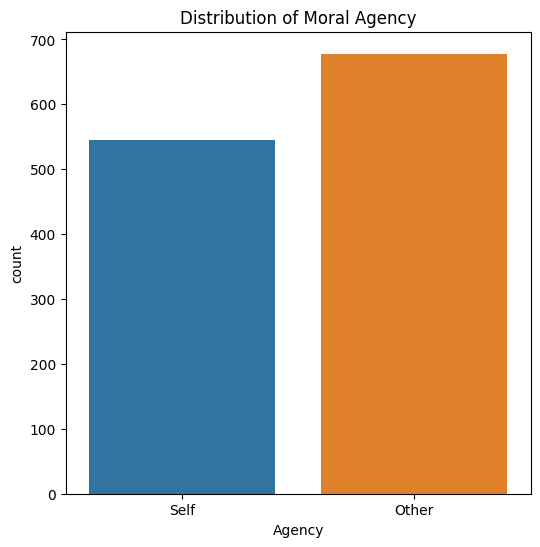

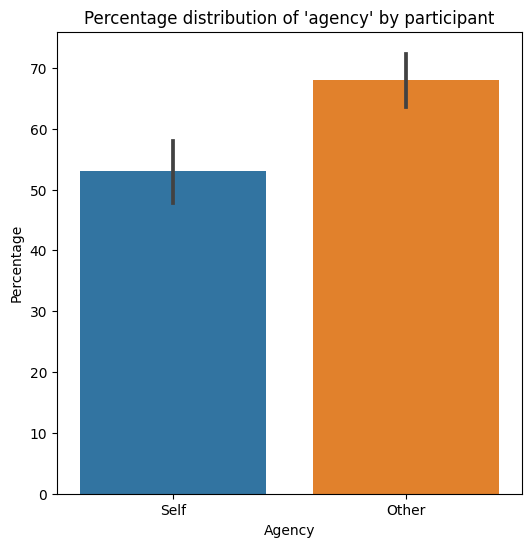

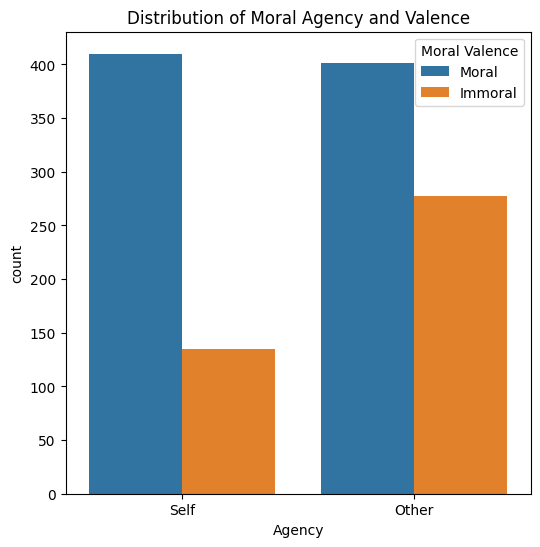

In [116]:
plt.figure(figsize=(6,6))
sns.countplot(data=dfnoneutral, x="moral_agency")
plt.title("Distribution of Moral Agency")
plt.xticks(ticks=[0,1], labels=["Self", "Other"])
plt.xlabel("Agency")
plt.show()

# calculate the percentage of each moral agency by participant_ID
counts = df.groupby('participant_ID')['moral_agency'].value_counts()
totals = df.groupby('participant_ID')['moral_agency'].count()
percentage_distribution = (counts / totals) * 100

# Reset the index and rename the columns for a more readable format
percentage_distribution = percentage_distribution.reset_index(name='percentage')

# Create the barplot
plt.figure(figsize=(6,6))
sns.barplot(data=percentage_distribution, x='moral_agency', y='percentage')
plt.title("Percentage distribution of 'agency' by participant")
plt.ylabel('Percentage')
plt.xlabel('Agency')
plt.xticks(ticks=[0,1], labels=["Self", "Other"])
plt.show()



plt.figure(figsize=(6,6))
sns.countplot(data=df, x="moral_agency", hue="moral_valence")
plt.title("Distribution of Moral Agency and Valence")
plt.xticks(ticks=[0,1], labels=[ "Self", "Other"])
plt.xlabel("Agency")
plt.legend(title="Moral Valence", labels=[ "Moral", "Immoral"])
plt.show()


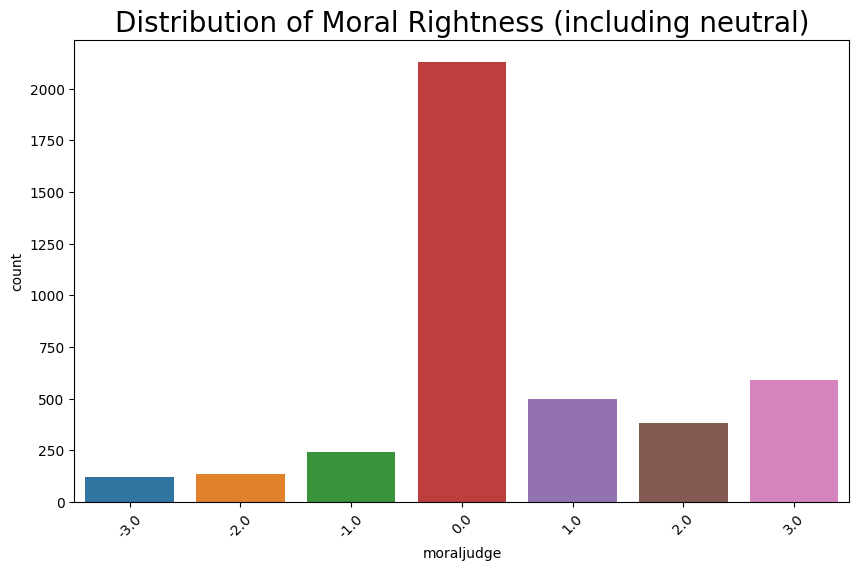

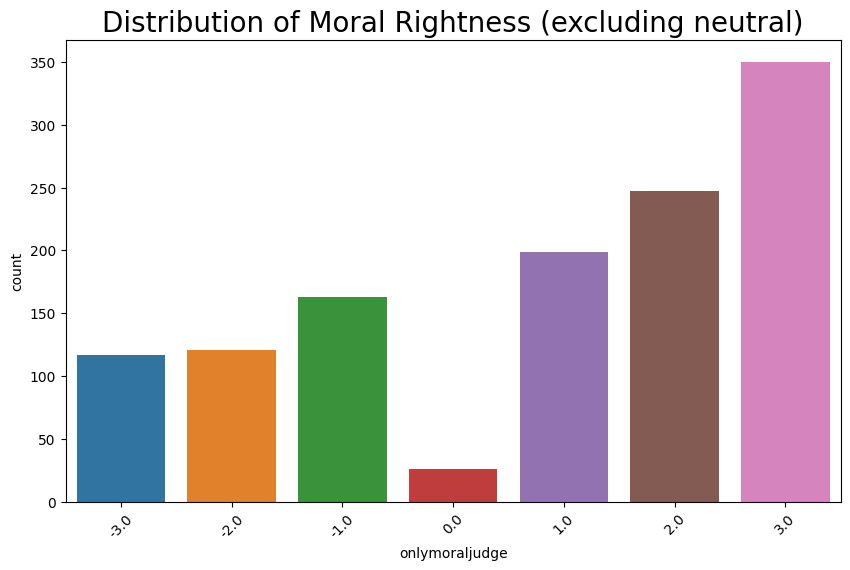

0

In [85]:
plt.figure(figsize=(10,6))
sns.countplot(data=dfnoneutral, x="moraljudge")
# larger font
plt.title("Distribution of Moral Rightness (including neutral)",fontsize=20)

plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='onlymoraljudge')
plt.title("Distribution of Moral Rightness (excluding neutral)",fontsize=20)
plt.xticks(rotation=45)
plt.show()

# amount of moraljudge missing
df['moraljudge'].isnull().sum()





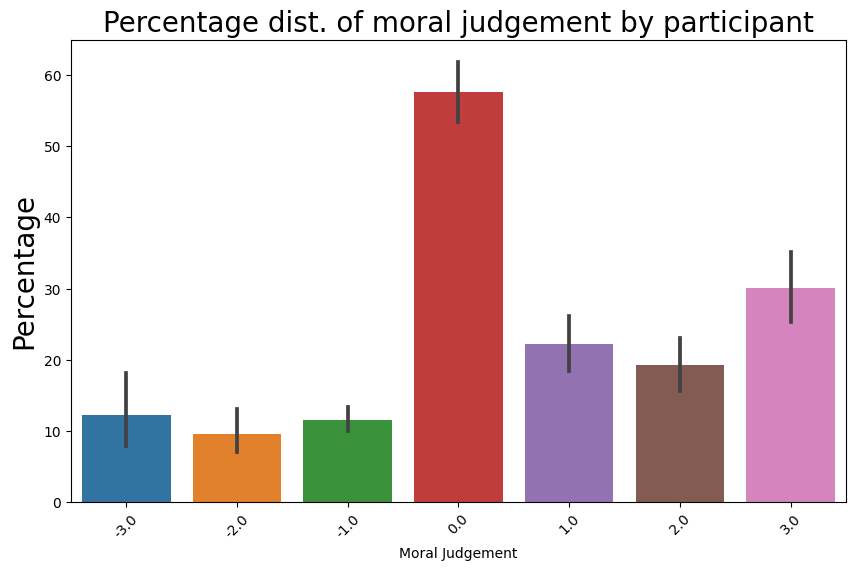

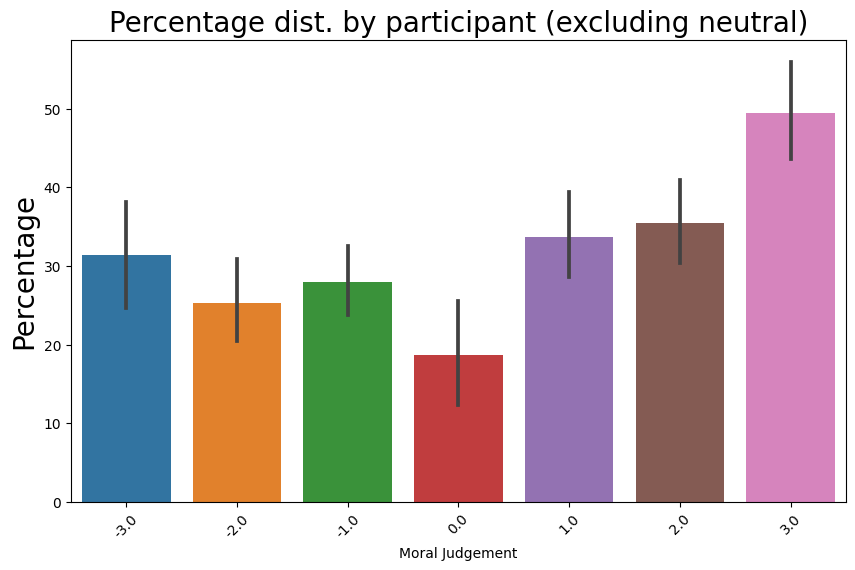

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
counts = df.groupby('participant_ID')['moraljudge'].value_counts()
totals = df.groupby('participant_ID')['moraljudge'].count()
percentage_distribution = (counts / totals) * 100
percentage_distribution = percentage_distribution.reset_index(name='percentage')
plt.figure(figsize=(10,6))
sns.barplot(data=percentage_distribution, x='moraljudge', y='percentage')
plt.title("Percentage dist. of moral judgement by participant",fontsize=20)
plt.ylabel('Percentage',fontsize=20)
plt.xlabel('Moral Judgement')
plt.xticks(rotation=45)
plt.show()


# Calculate the percentage distribution as before
counts = df.groupby('participant_ID')['onlymoraljudge'].value_counts()
totals = df.groupby('participant_ID')['onlymoraljudge'].count()
percentage_distribution = (counts / totals) * 100

# Reset the index and rename the columns for a more readable format
percentage_distribution = percentage_distribution.reset_index(name='percentage')

# Create the barplot
plt.figure(figsize=(10,6))
sns.barplot(data=percentage_distribution, x='onlymoraljudge', y='percentage')
plt.title("Percentage dist. by participant (excluding neutral)",fontsize=20)
plt.ylabel('Percentage',fontsize=20)
plt.xlabel('Moral Judgement')
plt.xticks(rotation=45)
plt.show()


## Emotional Experience

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


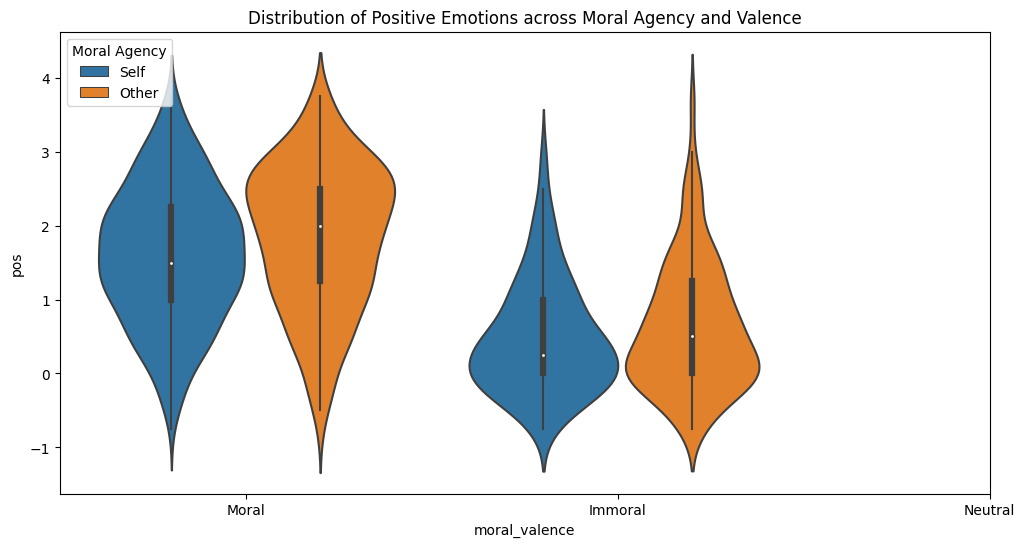

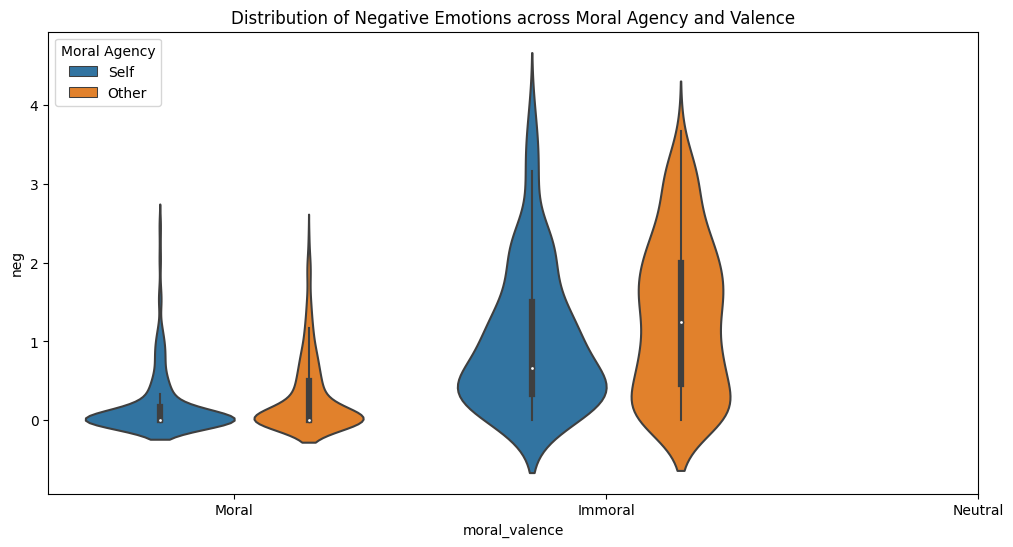

In [131]:
plt.figure(figsize=(12,6))
sns.violinplot(x="moral_valence", y="pos", hue="moral_agency", data=df)
plt.title("Distribution of Positive Emotions across Moral Agency and Valence")
plt.xticks(ticks=[0,1,2], labels=[ "Moral", "Immoral","Neutral"])
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Self", "Other"]
plt.legend(handles, labels, title="Moral Agency", loc='upper left')
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(x="moral_valence", y="neg", hue="moral_agency", data=df)
plt.title("Distribution of Negative Emotions across Moral Agency and Valence")
plt.xticks(ticks=[0,1,2], labels=[ "Moral", "Immoral","Neutral"])
handles, labels = plt.gca().get_legend_handles_labels()
labels = [ "Self", "Other"]
plt.legend(handles, labels, title="Moral Agency", loc='upper left')
plt.show()


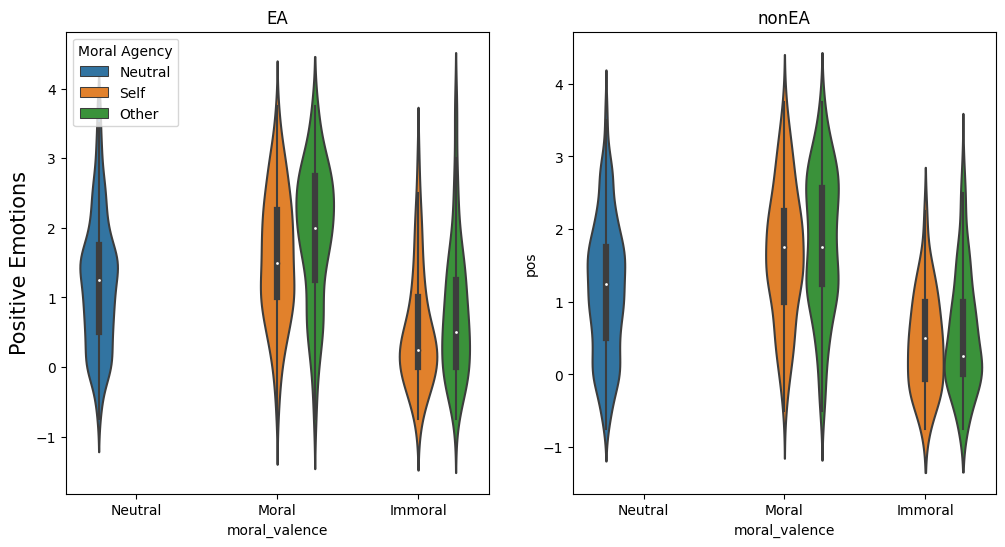

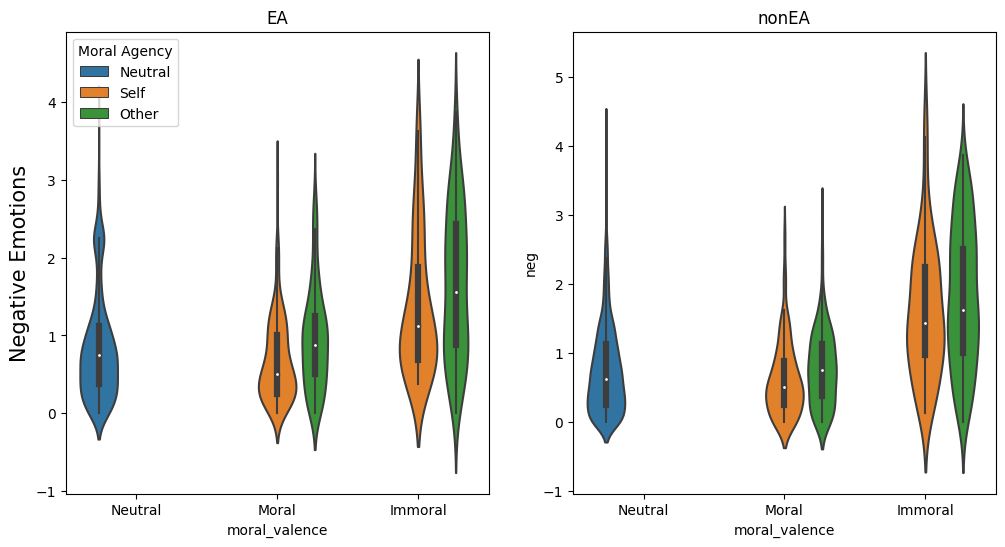

In [161]:
# plot tone_pos violines across moral agency and moral valences comparing EA and nonEA groups, 1x2 horizontally
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(x="moral_valence", y="pos", hue="moral_agency", data=df[df['group'] == 'EA'], ax=axes[0])
axes[0].set_title("EA")
axes[0].set_ylabel("Positive Emotions", fontsize=15)
axes[0].set_xticks(ticks=[0,1,2])
axes[0].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Neutral", "Self", "Other"]
axes[0].legend(handles, labels, title="Moral Agency", loc='upper left')

sns.violinplot(x="moral_valence", y="pos", hue="moral_agency", data=df[df['group'] == 'nonEA'], ax=axes[1])
axes[1].set_title("nonEA")
axes[1].set_xticks(ticks=[0,1,2])
axes[1].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
# ignore the legend for the second plot
axes[1].legend([],[], frameon=False)
plt.show()

# plot tone_neg violines across moral agency and moral valences comparing EA and nonEA groups, 1x2 horizontally
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(x="moral_valence", y="neg", hue="moral_agency", data=df[df['group'] == 'EA'], ax=axes[0])
axes[0].set_title("EA")
axes[0].set_ylabel("Negative Emotions", fontsize=15)
axes[0].set_xticks(ticks=[0,1,2])
axes[0].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Neutral", "Self", "Other"]
axes[0].legend(handles, labels, title="Moral Agency", loc='upper left')

sns.violinplot(x="moral_valence", y="neg", hue="moral_agency", data=df[df['group'] == 'nonEA'], ax=axes[1])
axes[1].set_title("nonEA")
axes[1].set_xticks(ticks=[0,1,2])
axes[1].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
axes[1].legend([],[], frameon=False)
plt.show()

# Linguistic analysis

## Word Cloud

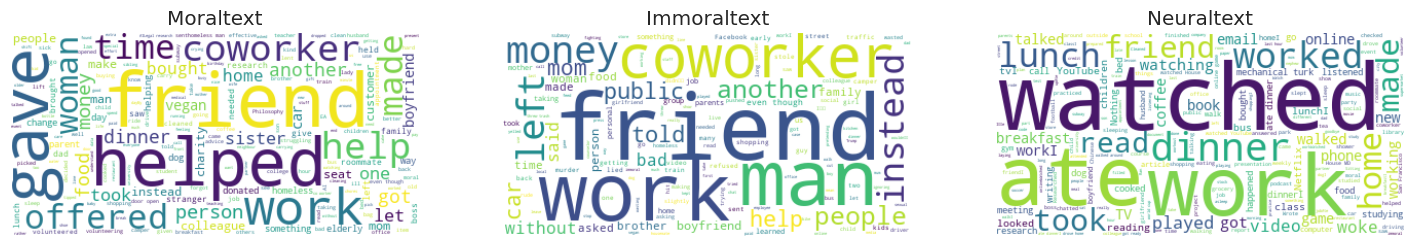

In [183]:
# word cloud for the free response
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["someone","went"])

df['moraltext'] = df['In as few words as you can, please tell us what the moral act was about.'].astype(str)
df['immoraltext'] = df['In as few words as you can, please tell us what the immoral act was about.'].astype(str)
df['neuraltext'] = df['In as few words as you can, tell us about something that happened to you, or something that you did in the past hour.'].astype(str)

# generate 3 wordclouds in a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(18,6))
textvar = ['moraltext', 'immoraltext', 'neuraltext']
for i, ax in enumerate(axes.flatten()):
    text = ''.join([t for t in df[textvar[i]] if t != 'nan'])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    # title is the textvar name with first letter capitalized
    ax.set_title(textvar[i].capitalize())
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")


Text(0.5, 0.98, 'Word Clouds for Moral Agency (Self vs. Others)')

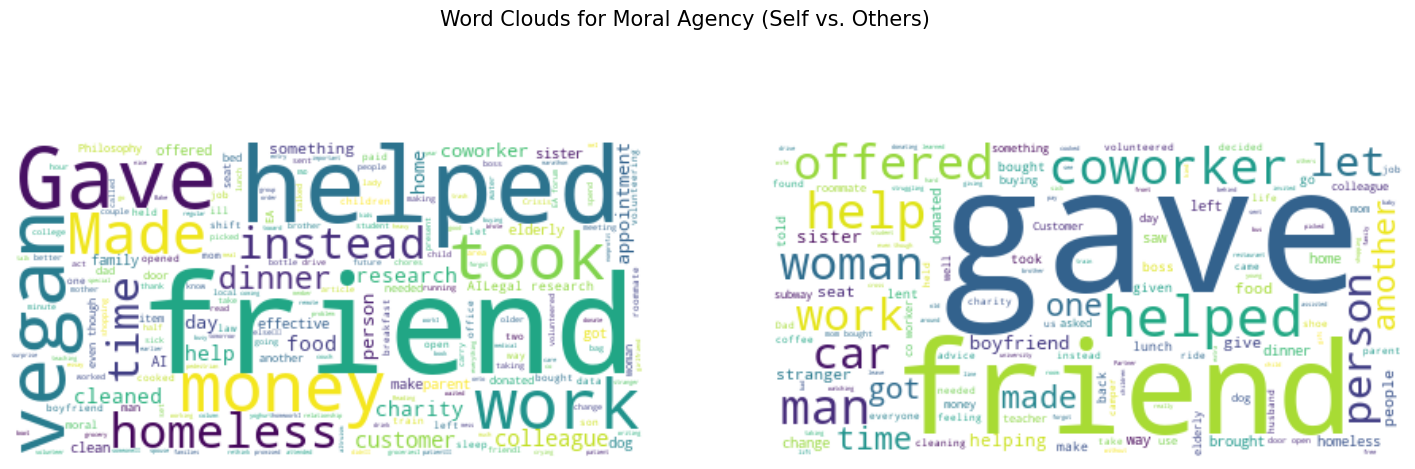

In [128]:
# word cloud for the free response
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["someone","went"])

df['moraltext'] = df['In as few words as you can, please tell us what the moral act was about.'].astype(str)
df['immoraltext'] = df['In as few words as you can, please tell us what the immoral act was about.'].astype(str)
df['neuraltext'] = df['In as few words as you can, tell us about something that happened to you, or something that you did in the past hour.'].astype(str)

# get moral and immoral text when moral agency is self
selftext = df[df['moral_agency'] == 1]['moraltext'].astype(str)
othertext = df[df['moral_agency'] == 2]['moraltext'].astype(str)

# generate 2 wordclouds in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(18,6))
textvar = [selftext, othertext]
for i, ax in enumerate(axes.flatten()):
    text = ''.join([t for t in textvar[i] if t != 'nan'])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
# add a title
fig.suptitle("Word Clouds for Moral Agency (Self vs. Others)", fontsize=15)

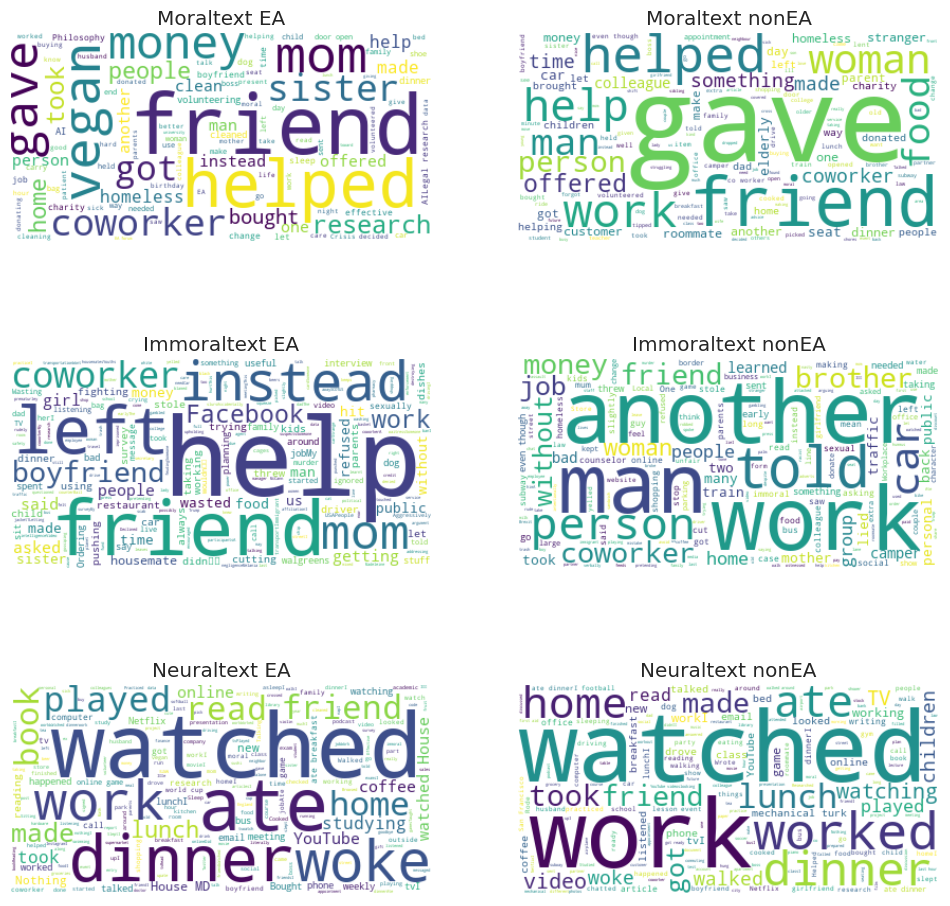

In [184]:
# generate wordclouds of textvar for each group EA and nonEA
fig, axes = plt.subplots(3,2, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    text = ''.join([t for t in df[df['group'] == ['EA', 'nonEA'][i % 2]][textvar[i // 2]] if t != 'nan'])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    # title is the textvar name with first letter capitalized
    ax.set_title(textvar[i // 2].capitalize() + ' ' + ['EA', 'nonEA'][i % 2])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

## LIWC

In [133]:
import numpy as np
dmoral = pd.read_csv(os.path.join(data_folder_path, 'LIWC-22 Results - EA_ema - moral.csv'))
dimmoral = pd.read_csv(os.path.join(data_folder_path, 'LIWC-22 Results - EA_ema - immoral.csv'))
dneutral = pd.read_csv(os.path.join(data_folder_path, 'LIWC-22 Results - EA_ema - neutral.csv'))

# merge the three dataframes into one
def replace_non_wc(df):
    mask = df['WC'] == 0
    df.loc[mask, df.columns != 'WC'] = np.nan
    return df

dmoral = replace_non_wc(dmoral)
dimmoral = replace_non_wc(dimmoral)
dneutral = replace_non_wc(dneutral)
dliwc = pd.concat([dmoral, dimmoral, dneutral], axis=0)
# delete rows if df['WC'] == 0
dliwc = dliwc[dliwc['WC'] != 0]
# sort by index
dliwc = dliwc.sort_index()
df = df.sort_index()
# merge dliwc with df on index
df = pd.merge(df, dliwc, left_index=True, right_index=True)
df.to_csv(os.path.join(out_folder_path, 'df.csv'), index=False)

In [135]:
# print colnames of dliwc
dliwc.columns

Index(['Segment', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'BigWords', 'Dic', 'Linguistic',
       ...
       'assent', 'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark',
       'Exclam', 'Apostro', 'OtherP'],
      dtype='object', length=118)

## Word Count

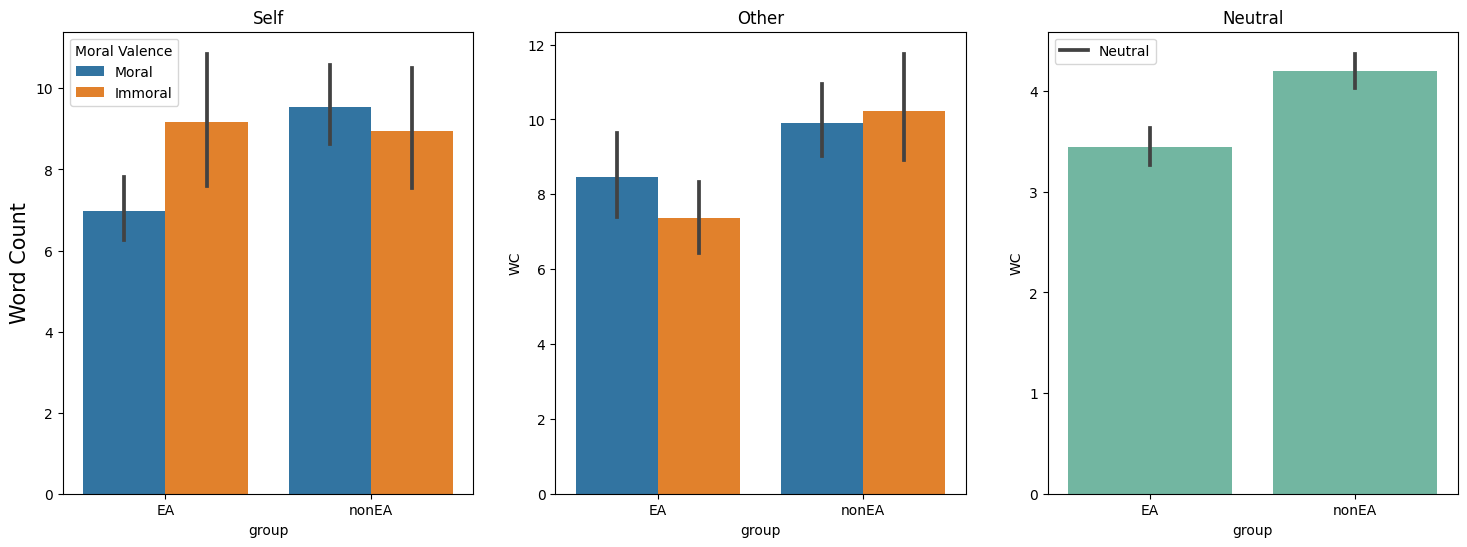

In [201]:
# plot WC across groups, controlling for frequency of EMA
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.barplot(x="group", y="WC", hue="moral_valence", data=df[df['moral_agency'] == 1], ax=axes[0])
axes[0].set_title("Self")
axes[0].set_ylabel("Word Count", fontsize=15)
axes[0].set_xticks(ticks=[0,1])
axes[0].set_xticklabels(labels=["EA", "nonEA"])
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Moral", "Immoral"]
axes[0].legend(handles, labels, title="Moral Valence", loc='upper left')

sns.barplot(x="group", y="WC", hue="moral_valence", data=df[df['moral_agency'] == 2], ax=axes[1])
axes[1].set_title("Other")
axes[1].set_xticks(ticks=[0,1])
axes[1].set_xticklabels(labels=["EA", "nonEA"])
axes[1].legend([],[], frameon=False)


sns.barplot(x="group", y="WC", hue="moral_valence", data=df[df['moral_agency'] == 0], ax=axes[2], palette='Set2')
axes[2].set_title("Neutral")
axes[2].set_xticks(ticks=[0,1])
axes[2].set_xticklabels(labels=["EA", "nonEA"])
axes[2].legend(['Neutral'])

plt.show()


Summary - Word Count

Generally, nonEA are more eloquent than EA when reporting event experiences. But when it comes to self-commited immoral acts, EA is more eloquent.

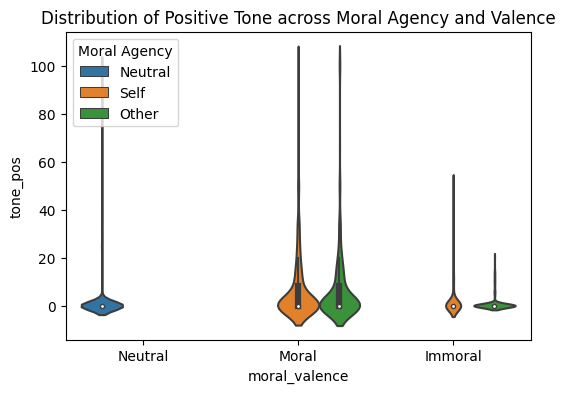

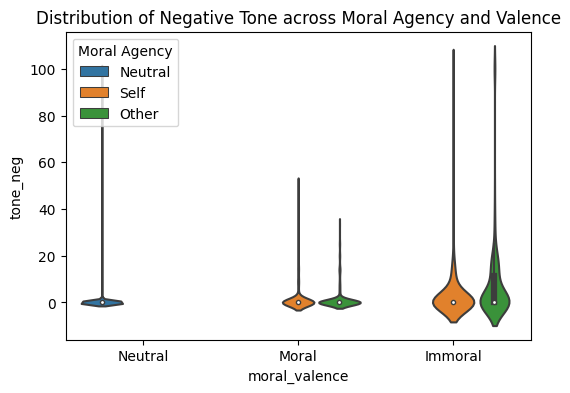

In [143]:
plt.figure(figsize=(6,4))
sns.violinplot(x="moral_valence", y="tone_pos", hue="moral_agency", data=df)
plt.title("Distribution of Positive Tone across Moral Agency and Valence")
plt.xticks(ticks=[0,1,2], labels=["Neutral", "Moral", "Immoral"])
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Neutral", "Self", "Other"]
plt.legend(handles, labels, title="Moral Agency", loc='upper left')
plt.show()

# plot tone_neg violines across moral agency and moral valences comparing groups
plt.figure(figsize=(6,4))
sns.violinplot(x="moral_valence", y="tone_neg", hue="moral_agency", data=df)
plt.title("Distribution of Negative Tone across Moral Agency and Valence")
plt.xticks(ticks=[0,1,2], labels=["Neutral", "Moral", "Immoral"])
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Neutral", "Self", "Other"]
plt.legend(handles, labels, title="Moral Agency", loc='upper left')
plt.show()


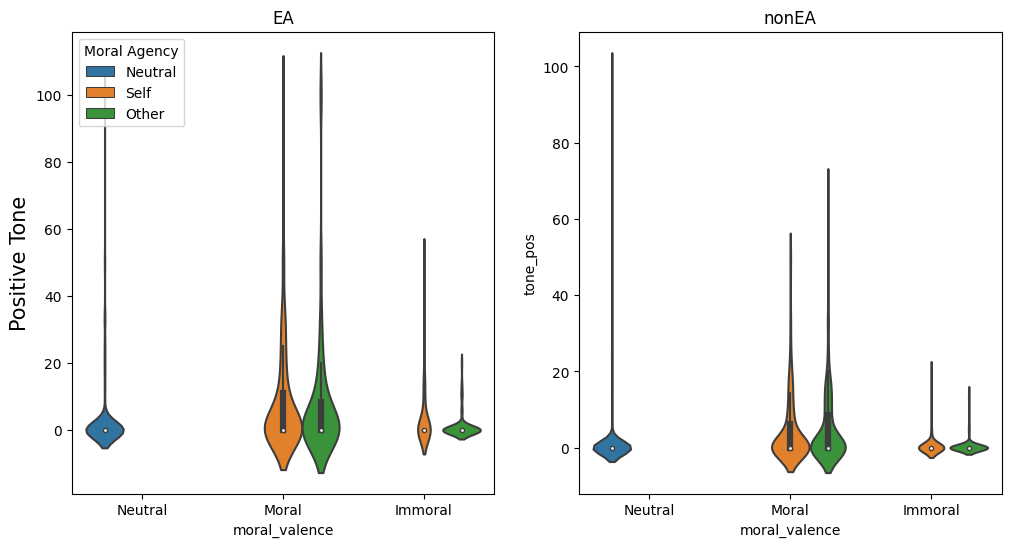

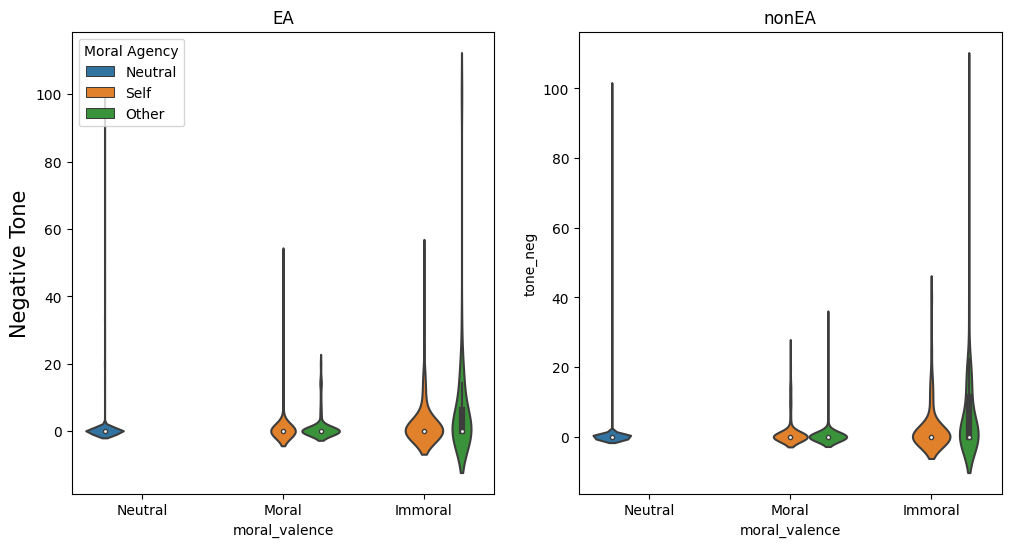

In [151]:
# plot tone_pos violines across moral agency and moral valences comparing EA and nonEA groups, 1x2 horizontally
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(x="moral_valence", y="tone_pos", hue="moral_agency", data=df[df['group'] == 'EA'], ax=axes[0])
axes[0].set_title("EA")
axes[0].set_ylabel("Positive Tone", fontsize=15)
axes[0].set_xticks(ticks=[0,1,2])
axes[0].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Neutral", "Self", "Other"]
axes[0].legend(handles, labels, title="Moral Agency", loc='upper left')

sns.violinplot(x="moral_valence", y="tone_pos", hue="moral_agency", data=df[df['group'] == 'nonEA'], ax=axes[1])
axes[1].set_title("nonEA")
axes[1].set_xticks(ticks=[0,1,2])
axes[1].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
# ignore the legend for the second plot
axes[1].legend([],[], frameon=False)
plt.show()

# plot tone_neg violines across moral agency and moral valences comparing EA and nonEA groups, 1x2 horizontally
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(x="moral_valence", y="tone_neg", hue="moral_agency", data=df[df['group'] == 'EA'], ax=axes[0])
axes[0].set_title("EA")
axes[0].set_ylabel("Negative Tone", fontsize=15)
axes[0].set_xticks(ticks=[0,1,2])
axes[0].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Neutral", "Self", "Other"]
axes[0].legend(handles, labels, title="Moral Agency", loc='upper left')

sns.violinplot(x="moral_valence", y="tone_neg", hue="moral_agency", data=df[df['group'] == 'nonEA'], ax=axes[1])
axes[1].set_title("nonEA")
axes[1].set_xticks(ticks=[0,1,2])
axes[1].set_xticklabels(labels=["Neutral", "Moral", "Immoral"])
axes[1].legend([],[], frameon=False)
plt.show()

In [154]:
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Summary Statistics of `tone_pos` and `tone_neg`
print("Summary Statistics of Positive Tone:")
print(df['tone_pos'].describe())

print("\nSummary Statistics of Negative Tone:")
print(df['tone_neg'].describe())

# Compare `tone_pos` and `tone_neg` between groups
EA_tone_pos = df[df['group'] == 'EA']['tone_pos']
nonEA_tone_pos = df[df['group'] == 'nonEA']['tone_pos']

EA_tone_neg = df[df['group'] == 'EA']['tone_neg']
nonEA_tone_neg = df[df['group'] == 'nonEA']['tone_neg']

print("\nT-test for Positive Tone between groups:")
print(ttest_ind(EA_tone_pos, nonEA_tone_pos, nan_policy='omit'))

print("\nT-test for Negative Tone between groups:")
print(ttest_ind(EA_tone_neg, nonEA_tone_neg, nan_policy='omit'))


Summary Statistics of Positive Tone:
count    4094.000000
mean        2.854384
std        10.082317
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: tone_pos, dtype: float64

Summary Statistics of Negative Tone:
count    4094.000000
mean        1.061483
std         6.082339
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: tone_neg, dtype: float64

T-test for Positive Tone between groups:
Ttest_indResult(statistic=4.26956364710524, pvalue=2.007371267911986e-05)

T-test for Negative Tone between groups:
Ttest_indResult(statistic=-0.03827577520786024, pvalue=0.9694698557343353)


In [156]:
# Frequency distribution of moral valence
print(df['moral_valence'].value_counts(normalize=True))

# Frequency distribution of moral agency
print(df['moral_agency'].value_counts(normalize=True))

# Cross-tabulation of moral valence and moral agency
print(pd.crosstab(df['moral_valence'], df['moral_agency'], normalize='all'))


moral_valence
0.0    0.701514
1.0    0.198095
2.0    0.100391
Name: proportion, dtype: float64
moral_agency
0.0    0.701514
2.0    0.165364
1.0    0.133122
Name: proportion, dtype: float64
moral_agency        0.0       1.0       2.0
moral_valence                              
0.0            0.701514  0.000000  0.000000
1.0            0.000000  0.100147  0.097948
2.0            0.000000  0.032975  0.067416


Summary - Moral Valence x Agency x Group on Tone

- When comparing the tone_pos variable between the EA and nonEA groups, there is a statistically significant difference (p < 0.001), with the EA group having a higher average positive tone. This suggests that the EA group may exhibit a more positive tone in their language use overall compared to the nonEA group.

- For the tone_neg variable, however, there's no significant difference between the two groups (p > 0.05), suggesting that both groups have similar levels of negative tone in their language use.

- From the frequency distributions, we can see that most events are labeled as neutral in terms of both moral valence and moral agency (about 70%). Moral events are the second most common (about 20%) while immoral events are the least common (about 10%). 

- for moral agency, events involving others are more common than events involving the self.

- The chi-square tests of independence show a very strong association between moral valence and moral agency within both EA and nonEA groups. This suggests that moral valence and moral agency are not independent; the moral agency (whether self or other) involved in an event is related to the moral valence (moral, immoral, or neutral) of the event. This holds true for both EA and nonEA groups.











# other LIWC

In [141]:
import scipy.stats as stats
# test the relationship between Analytic and OUS_IB and OUS_IH, ignore missing  values
df_cleaned = df[['Analytic', 'OUS_IB']].dropna()
print(stats.pearsonr(df_cleaned['Analytic'], df_cleaned['OUS_IB']))

df_cleaned = df[['Analytic', 'OUS_IH']].dropna()
print(stats.pearsonr(df_cleaned['Analytic'], df_cleaned['OUS_IH']))


PearsonRResult(statistic=-0.04062380631832441, pvalue=0.01311709976063362)
PearsonRResult(statistic=-0.011815400536767807, pvalue=0.4707862931482511)


In [145]:
from scipy.stats import ttest_ind, pearsonr
# test whether groups differ in Analytic
EA_analytic = df[df['group'] == 'EA']['Analytic']
nonEA_analytic = df[df['group'] == 'nonEA']['Analytic']
print(stats.ttest_ind(EA_analytic, nonEA_analytic, nan_policy='omit'))


Ttest_indResult(statistic=0.9279070479753259, pvalue=0.3535158912427634)


In [142]:
# test the relationship between Social and OUS_IB and OUS_IH, ignore missing  values
df_cleaned = df[['Social', 'OUS_IB']].dropna()
print(stats.pearsonr(df_cleaned['Social'], df_cleaned['OUS_IB']))

df_cleaned = df[['Social', 'OUS_IH']].dropna()
print(stats.pearsonr(df_cleaned['Social'], df_cleaned['OUS_IH']))

PearsonRResult(statistic=0.030328549226145828, pvalue=0.06408533017530774)
PearsonRResult(statistic=-0.07240232481356504, pvalue=9.643347340672973e-06)


In [146]:
# test whether groups differ in Social
EA_social = df[df['group'] == 'EA']['Social']
nonEA_social = df[df['group'] == 'nonEA']['Social']
print(stats.ttest_ind(EA_social, nonEA_social, nan_policy='omit'))

Ttest_indResult(statistic=2.1492783305829506, pvalue=0.031676557838331676)


In [ ]:
# test

## compare LIWC and self-report emotions

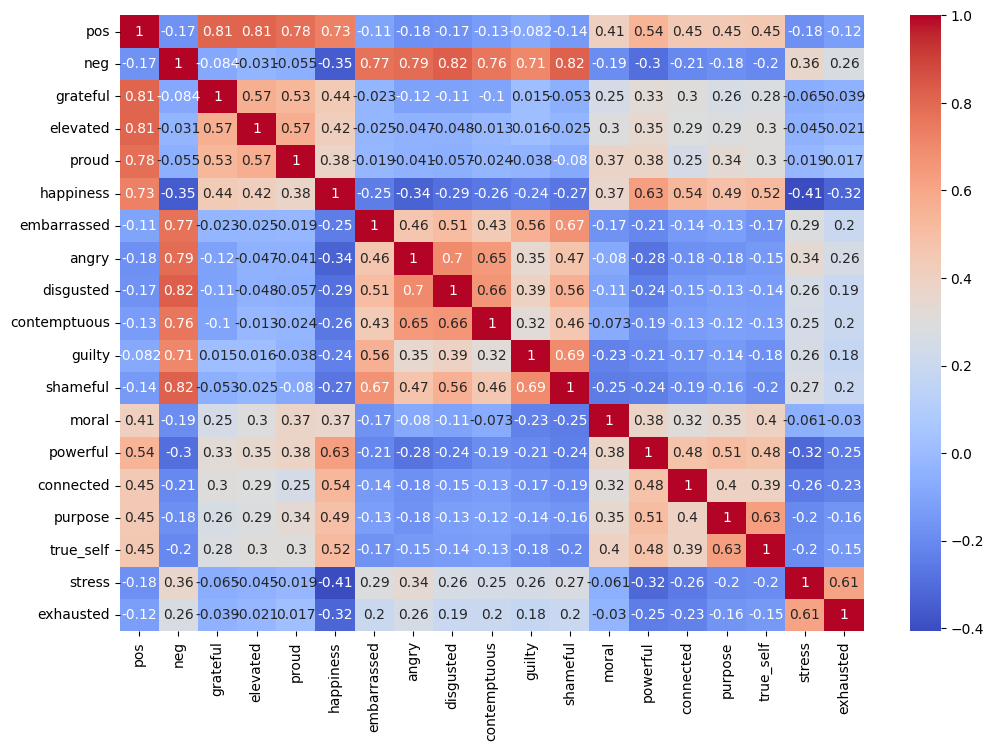

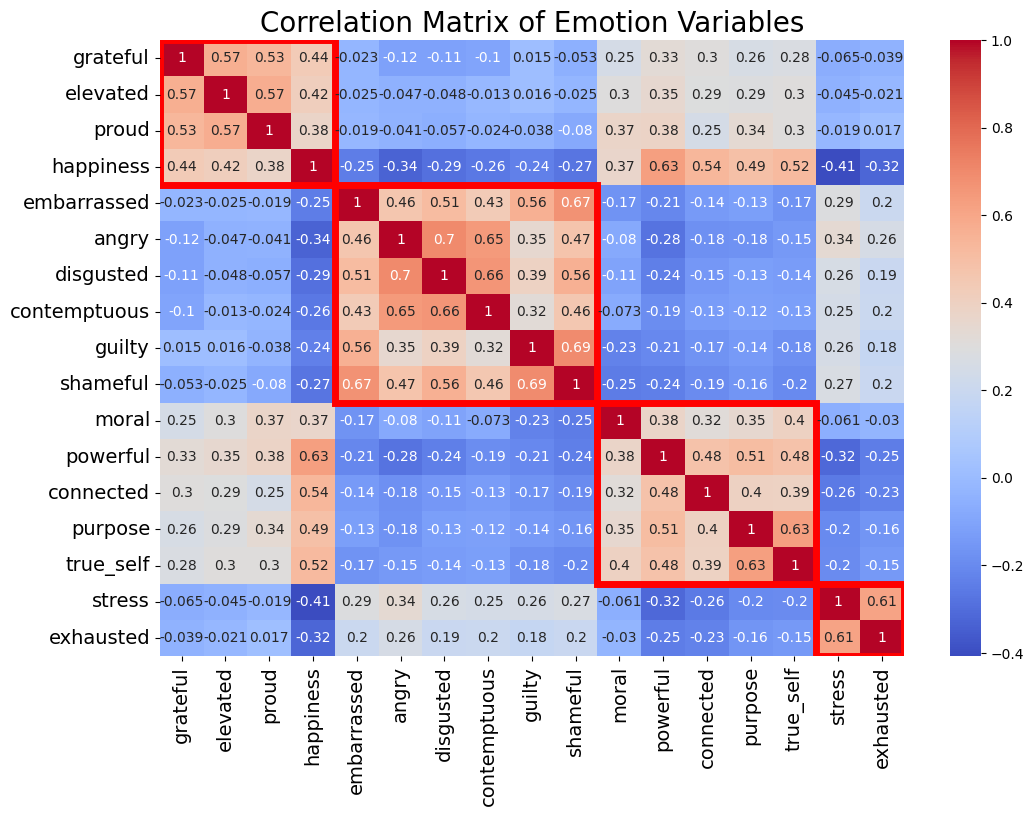

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# generate matrix of correlations between tone_pos, tone_neg, pos, neg, and positive_varnames, negative_varnames
all_varnames = ['pos', 'neg'] + positive_varnames  +negative_varnames+['moral','powerful','connected','purpose','true_self'] + ['stress','exhausted']
corr = df[all_varnames].corr()
# plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')



import matplotlib.patches as patches


# generate matrix of correlations between variables
all_varnames = positive_varnames + negative_varnames + ['moral', 'powerful', 'connected', 'purpose', 'true_self'] + ['stress', 'exhausted']
corr = df[all_varnames].corr()

# plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# list of clusters to highlight
clusters = [
    # each tuple represents a cluster of correlated variables, defined by (start_row, start_col, height, width)
    (0, 0, 4, 4), 
    (4, 4, 6, 6),
    (10, 10, 5, 5),
    (15, 15, 2, 2)
]
# add boxes for each cluster
ax = plt.gca()
for cluster in clusters:
    start_row, start_col, height, width = cluster
    rect = patches.Rectangle((start_col, start_row), width, height, linewidth=5, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# set title and increase label sizes
plt.title('Correlation Matrix of Emotion Variables', fontsize=20)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

plt.show()

In [137]:
# test correlation between tone_pos and pos
from scipy.stats import pearsonr
print(pearsonr(df['emo_pos'], df['pos']))
print(pearsonr(df['emo_neg'], df['neg']))
print(pearsonr(df['tone_pos'], df['pos']))
print(pearsonr(df['tone_neg'], df['neg']))

PearsonRResult(statistic=-0.007415057237228009, pvalue=0.6352792695820614)
PearsonRResult(statistic=0.11238499199235245, pvalue=5.532118437379349e-13)
PearsonRResult(statistic=0.0663715327628765, pvalue=2.1364565234752264e-05)
PearsonRResult(statistic=0.16260803296549378, pvalue=1.1745152937368104e-25)


Summary

Overall, these results suggest that the lingustic tone of the text responses (as captured by tone_pos and tone_neg) does have a relationship with the self-reported emotions (pos and neg). 

- However, the strength of these relationships is fairly weak to moderate, suggesting that other factors not measured in this study could also be influencing these emotional responses. 

- Additionally, the non-significant correlation between emo_pos and pos indicates that these variables are not related in a linear manner, at least within the context of this study.

# Utilitarism

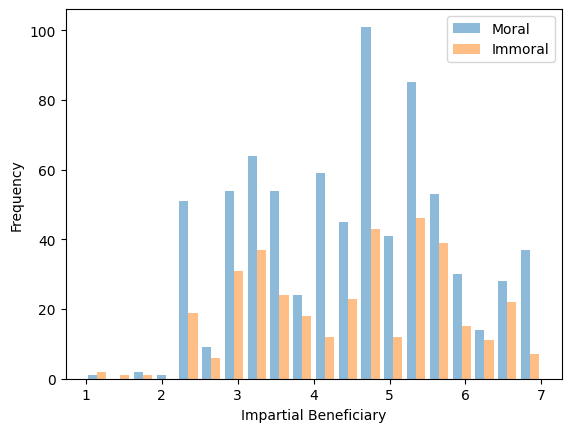

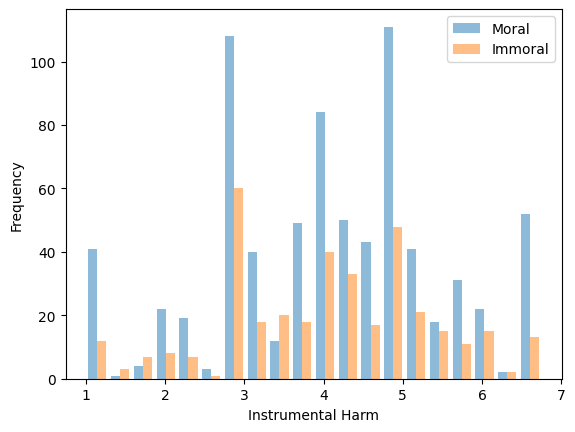

In [290]:
plt.hist([df[df['moral_valence'] == 1]['OUS_IB'], df[df['moral_valence'] == 2]['OUS_IB']], stacked=False, bins=20, alpha=0.5, label=['Moral', 'Immoral'])
plt.legend(loc='upper right')
plt.xlabel('Impartial Beneficiary')
plt.ylabel('Frequency')
plt.show()

plt.hist([df[df['moral_valence'] == 1]['OUS_IH'], df[df['moral_valence'] == 2]['OUS_IH']], stacked=False, bins=20, alpha=0.5, label=['Moral', 'Immoral'])
plt.legend(loc='upper right')
plt.xlabel('Instrumental Harm')
plt.ylabel('Frequency')
plt.show()


Text(0, 0.5, 'Frequency')

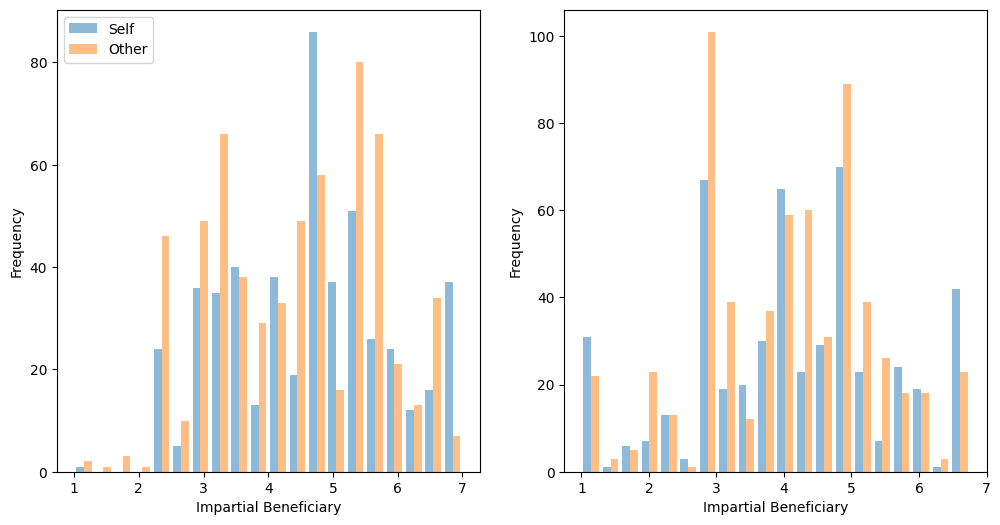

In [288]:
# plot hist of event divided by moral agency and OUS
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].hist([df[df['moral_agency'] == 1]['OUS_IB'], df[df['moral_agency'] == 2]['OUS_IB']], stacked=False, bins=20, alpha=0.5, label=['Self', 'Other'])
axes[0].legend(loc='upper left')
axes[0].set_xlabel("Impartial Beneficiary")
axes[0].set_ylabel("Frequency")

axes[1].hist([df[df['moral_agency'] == 1]['OUS_IH'], df[df['moral_agency'] == 2]['OUS_IH']], stacked=False, bins=20, alpha=0.5, label=['Self', 'Other'])
axes[1].set_xlabel("Impartial Beneficiary")
axes[1].set_ylabel("Frequency")


## Mlogit: OUS on moral experiences

In [206]:
out_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/out')
df.to_csv(os.path.join(out_folder_path,'df.csv'), index=False)


## HLM: OUS x valence x agency on emotions

In [28]:
# conduct a HLM analysis, pos as DV, OUS_IB, moral valence, and moral agency and their interactions as IVs, and participant as random effect
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Drop rows with missing values
df = df.dropna(subset=["pos", "OUS_IB", "moral_valence", "moral_agency", "participant_ID"])

# Ensure 'participant' is a categorical variable
df['participant'] = df['participant_ID'].astype('category')
df['moral_valence'] = df['moral_valence'].astype('category')
df['moral_agency'] = df['moral_agency'].astype('category')
# Define the model
model = smf.mixedlm("pos ~ OUS_IB + moral_valence + moral_agency", df, groups=df["participant"], re_formula="~OUS_IB")

# Fit the model
result = model.fit()

# Print out the summary statistics of the fit
print(result.summary())

/home/local/PSYCH-ADS/xuqian_chen/anaconda3/envs/jupyter_env/envs/ngram/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/local/PSYCH-ADS/xuqian_chen/anaconda3/envs/jupyter_env/envs/ngram/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/local/PSYCH-ADS/xuqian_chen/anaconda3/envs/jupyter_env/envs/ngram/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   pos       
No. Observations:   3729      Method:               REML      
No. Groups:         171       Scale:                0.5108    
Min. group size:    1         Log-Likelihood:       -4242.9079
Max. group size:    42        Converged:            Yes       
Mean group size:    21.8                                      
--------------------------------------------------------------
                     Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             1.048    0.187 5.595 0.000  0.681  1.415
moral_valence[T.1.0]  8.767                                   
moral_valence[T.2.0]  7.662                                   
moral_agency[T.1.0]  -8.348                                   
moral_agency[T.2.0]  -8.257                                   
OUS_IB                0.042    0.042 0.983 0.326 -0.042  0.125
Group

/home/local/PSYCH-ADS/xuqian_chen/anaconda3/envs/jupyter_env/envs/ngram/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


## Moral Discounting

In [277]:
df['moral_agency']

0       1.0
1       2.0
2       1.0
3       NaN
4       NaN
       ... 
4090    NaN
4091    NaN
4092    NaN
4093    NaN
4095    2.0
Name: moral_agency, Length: 4095, dtype: float64

In [281]:

dft = pd.DataFrame()

# subset when agency == self and other
dfself = df[df['moral_agency'] == 1]
dfother = df[df['moral_agency'] == 2]
# calculate the correlation between moraljudge and pos for each participant
dft['corr_coeff'] = dfother.groupby('participant_ID').apply(lambda x: x['moraljudge'].corr(x['pos']))

# Small correction value
epsilon = 1e-7

# Apply correction to correlation coefficients and then compute z-scores
dft['corr_coeff'] = np.where(dft['corr_coeff'] <= -1 + epsilon, -1 + epsilon, dft['corr_coeff'])
dft['corr_coeff'] = np.where(dft['corr_coeff'] >= 1 - epsilon, 1 - epsilon, dft['corr_coeff'])

# Calculate Fisher z-transform
dft['corr_coeff_z'] = np.arctanh(dft['corr_coeff'])


# merge OUS_IB and OUS_IH from dfintake based on participant_ID
dft = pd.merge(dft, dfintake[['OUS_IB', 'OUS_IH', 'participant_ID']], on='participant_ID', how='left')

dft.to_csv(os.path.join(out_folder_path,'dfother.csv'), index=False)

/home/local/PSYCH-ADS/xuqian_chen/anaconda3/envs/jupyter_env/envs/ngram/lib/python3.9/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/local/PSYCH-ADS/xuqian_chen/anaconda3/envs/jupyter_env/envs/ngram/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


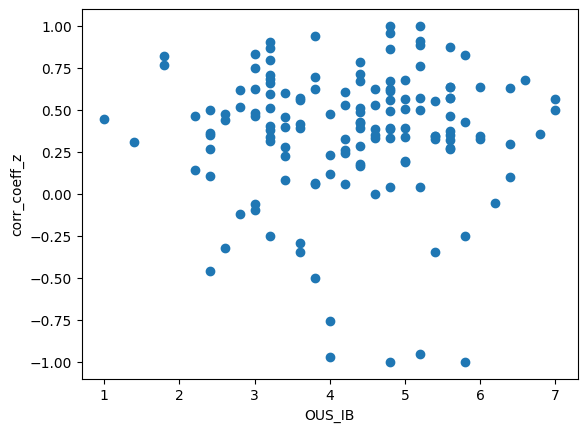

In [252]:
# plot corr_coeff_z against OUS_IB
plt.scatter(dft['OUS_IB'], dft['corr_coeff'])
plt.xlabel('OUS_IB')
plt.ylabel('corr_coeff_z')
plt.show()



(array([ 4.,  0.,  1.,  0.,  1.,  1.,  3.,  3.,  1.,  4.,  6.,  8., 10.,
        26., 18., 18., 19.,  7.,  7.,  6.]),
 array([-9.99999900e-01, -8.99999910e-01, -7.99999920e-01, -6.99999930e-01,
        -5.99999940e-01, -4.99999950e-01, -3.99999960e-01, -2.99999970e-01,
        -1.99999980e-01, -9.99999900e-02,  1.11022302e-16,  9.99999900e-02,
         1.99999980e-01,  2.99999970e-01,  3.99999960e-01,  4.99999950e-01,
         5.99999940e-01,  6.99999930e-01,  7.99999920e-01,  8.99999910e-01,
         9.99999900e-01]),
 <BarContainer object of 20 artists>)

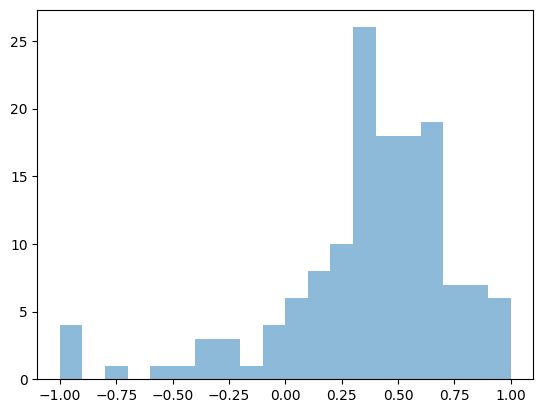

In [264]:
plt.hist(dft['corr_coeff'], bins=20, alpha=0.5, label='corr_coeff_z')
